In [2]:
#packages
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import csr_matrix

In [3]:
#functions
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

def svd_sketching_error(S):
    """
    Computes the SVD-based sketching error:
    - Deviation of max singular value from 1
    - Deviation of min singular value from 1

    Parameters:
    S (numpy.ndarray): The sketch matrix.

    Returns:
    tuple: (1 - min_singular_value, 1 - max_singular_value)
    """
    # Compute singular values
    singular_values = np.linalg.svd(S, compute_uv=False)

    # Min and max singular values
    min_svd = np.min(singular_values)
    max_svd = np.max(singular_values)

    # Compute deviations from 1
    min_svd_error = abs(1 - min_svd)
    max_svd_error = abs(1 - max_svd)

    return min_svd_error, max_svd_error

#svd of matrix
def compute_svd(matrix):
    # SVD computation only keep the singular values
    _, s, _ = np.linalg.svd(matrix, full_matrices=False)
    return np.min(s), np.max(s)

#Higher leverage scores indicate more influential data points.
def estimate_leverage_scores(A, R, gamma):
    """Estimate leverage scores ˜li for each row using matrix R (similar to Lemma 5.1)."""
    n, d = A.shape
    k = int(np.ceil(d / gamma))  # Choose k based on γ
    G = np.random.randn(d, k) / np.sqrt(k) #scale the matrix
    
    # Compute the leverage scores ˜li = || e_i^T AR G ||_2^2
    ARG = A @ (R @ G)
    leverage_scores = np.sum(ARG ** 2, axis=1)  # || e_i^T AR G ||_2^2
    
    return leverage_scores

def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.001, gamma=0.1, batch_size=10):
    """
    Fast least squares via preconditioned mini-batch SGD using sketch matrix and leverage scores.
    
    Parameters:
    - A: (n, d) NumPy array (or sparse matrix), the design matrix.
    - b: (n,) NumPy array, the target vector.
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    min_svd_error, max_svd_error = svd_sketching_error(S)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x , min_svd_error , max_svd_error

In [4]:
sketch_matrix(5,3,1)

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [5]:
n, d = 10000, 100 
m = min(2 * d, n)  # Typically 2d rows for sketch matrix
non_zero_entries = 10
A = np.random.randn(n, d)  # Design matrix A
x_true = np.random.randn(d)  # True solution vector x
b = A @ x_true + np.random.randn(n) * 0.1


# Estimate the solution using the algorithm
x_estimated, _, _ = fast_least_squares_sgd(A, b, 10, m)


In [6]:
mse = np.mean((x_estimated - x_true) ** 2)
mse

6.879682750419448e-05

In [7]:
# Solve least squares using NumPy's lstsq (normal OLS solution)
x_ols = np.linalg.lstsq(A, b, rcond=None)[0]

# Calculate the MSE for OLS
mse_ols = np.mean((x_ols - x_true) ** 2)
mse_ols

1.0894510832471958e-06

In [21]:
#varying m
# Define parameters
n, d = 10000, 100  # Matrix size
m_values = list(range(100,7000 + 1, 100))  # Different sketch sizes
non_zero_entries = 10
# Store results
results = []

for m in m_values:
    # Generate new A and b
    A = np.random.randn(n, d)
    x_true = np.random.randn(d)
    b = A @ x_true + np.random.randn(n) * 0.1
    # Compute estimated x
    x_estimated, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    mse = np.mean((x_estimated - x_true) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results = pd.DataFrame(results)

In [24]:
df_results.head()

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error
0,100,0.002229,10,8.083957,9.979134,9.979134
1,200,0.000126,10,5.108946,7.036962,7.036962
2,300,0.000049,10,3.757088,5.764842,5.764842
3,400,0.000032,10,3.017901,4.982842,4.982842
4,500,0.000028,10,2.454534,4.457422,4.457422


In [25]:
df_results['sketching_error'] = df_results[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error
0,100,0.002229,10,8.083957,9.979134,9.979134
1,200,0.000126,10,5.108946,7.036962,7.036962
2,300,0.000049,10,3.757088,5.764842,5.764842
3,400,0.000032,10,3.017901,4.982842,4.982842
4,500,0.000028,10,2.454534,4.457422,4.457422
...,...,...,...,...,...,...
65,6600,0.000002,10,0.771851,1.238617,1.238617
66,6700,0.000003,10,0.786914,1.231235,1.231235
67,6800,0.000002,10,0.794347,1.224186,1.224186
68,6900,0.000003,10,0.797824,1.230685,1.230685


In [28]:
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)

In [30]:
df_results.to_csv('varying_m_dataframe_application.csv', index=False)

In [32]:
sorted_df = df_results.sort_values(by='sketching_error', ascending=True)
sorted_df

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
69,7000,0.000002,10,0.804455,1.204393,1.204393,0.689387
67,6800,0.000002,10,0.794347,1.224186,1.224186,0.667276
68,6900,0.000003,10,0.797824,1.230685,1.230685,0.660246
66,6700,0.000003,10,0.786914,1.231235,1.231235,0.659657
65,6600,0.000002,10,0.771851,1.238617,1.238617,0.651818
...,...,...,...,...,...,...,...
4,500,0.000028,10,2.454534,4.457422,4.457422,0.050331
3,400,0.000032,10,3.017901,4.982842,4.982842,0.040276
2,300,0.000049,10,3.757088,5.764842,5.764842,0.030090
1,200,0.000126,10,5.108946,7.036962,7.036962,0.020194


In [ ]:
#varying m
# Define parameters
n, d = 10000, 100  # Matrix size
m_values = list(range(7100,n + 1, 100))  # Different sketch sizes
non_zero_entries = 10
# Store results
results = []
# Generate new A and b
A = np.random.randn(n, d)
x_true = np.random.randn(d)
b = A @ x_true + np.random.randn(n) * 0.1

for m in m_values:
    # Compute estimated x
    x_estimated, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    mse = np.mean((x_estimated - x_true) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results2 = pd.DataFrame(results)

In [10]:
df_results2['sketching_error'] = df_results2[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results2["inv_squared_sketching_error"] = 1 / (df_results2["sketching_error"] ** 2)
df_results2

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,7100,0.000002,10,0.814936,1.193630,1.193630,0.701876
1,7200,0.000002,10,0.845611,1.191438,1.191438,0.704461
2,7300,0.000003,10,0.828950,1.186053,1.186053,0.710873
3,7400,0.000002,10,0.837346,1.186251,1.186251,0.710635
4,7500,0.000002,10,0.846541,1.160094,1.160094,0.743043
5,7600,0.000002,10,0.864150,1.178677,1.178677,0.719798
6,7700,0.000002,10,0.862761,1.154732,1.154732,0.749959
7,7800,0.000002,10,0.869271,1.148047,1.148047,0.758718
8,7900,0.000002,10,0.878135,1.139768,1.139768,0.769781
9,8000,0.000002,10,0.885531,1.136235,1.136235,0.774576


In [11]:
df = pd.read_csv('../Dataset/varying_m_dataframe_application.csv')
df

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,100,0.002229,10,8.083957,9.979134,9.979134,0.010042
1,200,0.000126,10,5.108946,7.036962,7.036962,0.020194
2,300,0.000049,10,3.757088,5.764842,5.764842,0.030090
3,400,0.000032,10,3.017901,4.982842,4.982842,0.040276
4,500,0.000028,10,2.454534,4.457422,4.457422,0.050331
...,...,...,...,...,...,...,...
65,6600,0.000002,10,0.771851,1.238617,1.238617,0.651818
66,6700,0.000003,10,0.786914,1.231235,1.231235,0.659657
67,6800,0.000002,10,0.794347,1.224186,1.224186,0.667276
68,6900,0.000003,10,0.797824,1.230685,1.230685,0.660246


In [12]:
df_merged = pd.concat([df, df_results2], ignore_index=True)
df_merged.to_csv('varying_m_data_application.csv', index=False)

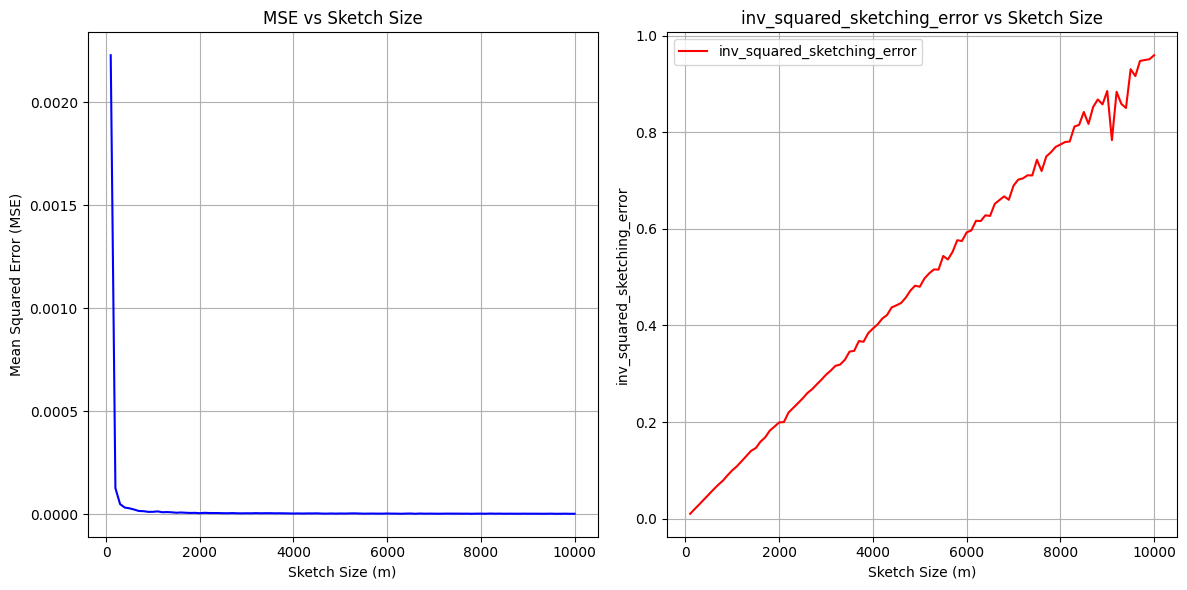

In [14]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_merged["m"], df_merged["MSE"], label="MSE", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sketch Size")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_merged["m"], df_merged["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sketch Size (m)")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sketch Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

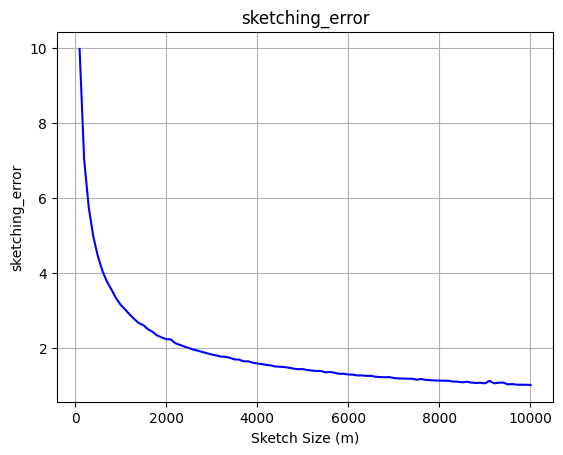

In [17]:
plt.plot(df_merged["m"], df_merged["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

In [16]:
df_merged.head(30)

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,100,0.002229,10,8.083957,9.979134,9.979134,0.010042
1,200,0.000126,10,5.108946,7.036962,7.036962,0.020194
2,300,0.000049,10,3.757088,5.764842,5.764842,0.030090
3,400,0.000032,10,3.017901,4.982842,4.982842,0.040276
4,500,0.000028,10,2.454534,4.457422,4.457422,0.050331
5,600,0.000022,10,2.014816,4.063411,4.063411,0.060565
6,700,0.000015,10,1.779833,3.775749,3.775749,0.070145
7,800,0.000014,10,1.541258,3.563157,3.563157,0.078764
8,900,0.000011,10,1.340442,3.332844,3.332844,0.090026
9,1000,0.000011,10,1.141143,3.159187,3.159187,0.100196


In [18]:
#varying s, elbow
n, d = 10000, 100  # Matrix size
m = 2000
non_zero_entries_list = list(range(2,m + 1 ,2))
# Store results
results = []
# Generate new A and b
A = np.random.randn(n, d)
x_true = np.random.randn(d)
b = A @ x_true + np.random.randn(n) * 0.1

for non_zero_entries in non_zero_entries_list:
    # Compute estimated x
    x_estimated, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    mse = np.mean((x_estimated - x_true) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results = pd.DataFrame(results)

In [20]:
df_results['sketching_error'] = df_results[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,2000,0.000006,2,0.337958,2.406275,2.406275,0.172707
1,2000,0.000006,4,0.180541,2.343743,2.343743,0.182046
2,2000,0.000005,6,0.191435,2.269694,2.269694,0.194118
3,2000,0.000007,8,0.207868,2.229745,2.229745,0.201136
4,2000,0.000006,10,0.234412,2.242164,2.242164,0.198914
...,...,...,...,...,...,...,...
995,2000,0.000006,1992,0.243786,2.228568,2.228568,0.201348
996,2000,0.000006,1994,0.240447,2.224278,2.224278,0.202126
997,2000,0.000007,1996,0.242257,2.236675,2.236675,0.199891
998,2000,0.000005,1998,0.235461,2.225481,2.225481,0.201907


In [21]:
df_results.to_csv('varying_s_data_application.csv', index=False)

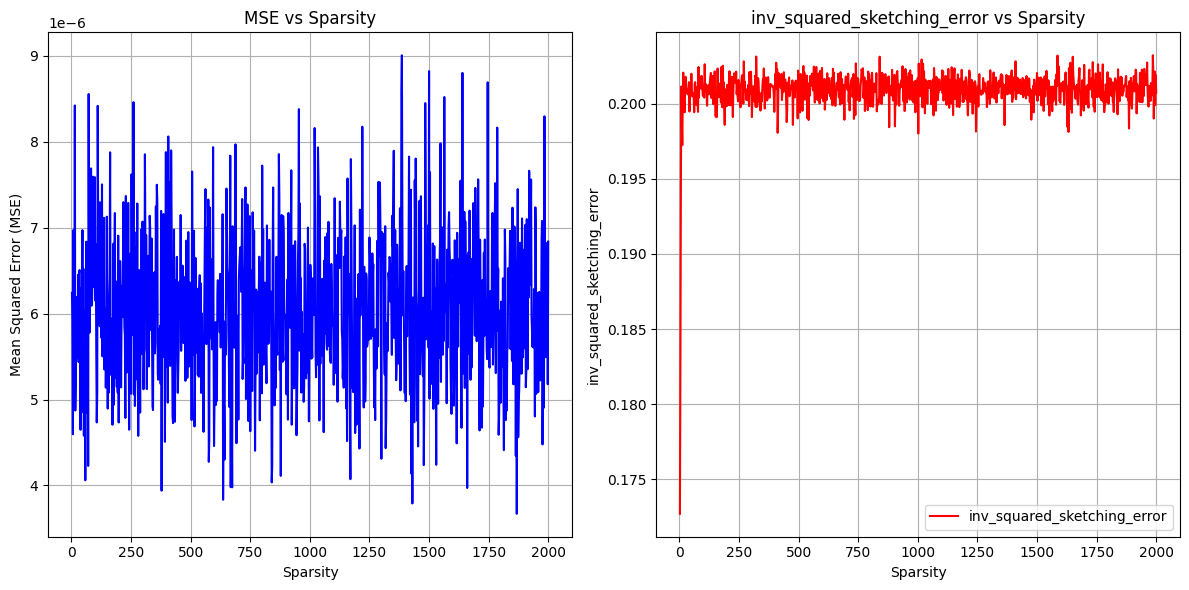

In [24]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["Sparsity"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sparsity")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["Sparsity"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sparsity")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sparsity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

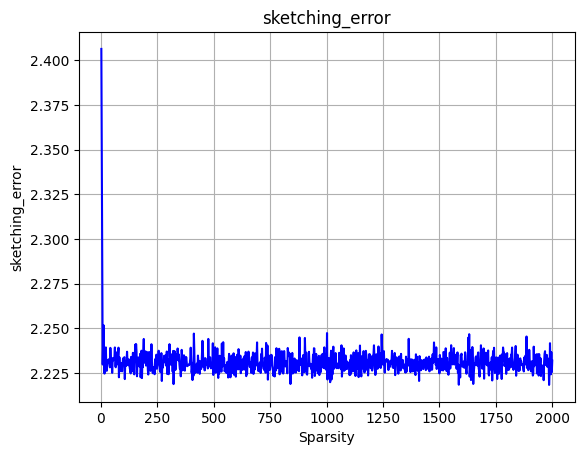

In [25]:
plt.plot(df_results["Sparsity"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

In [26]:
df_filtered = df_results[df_results["Sparsity"] <= 50]

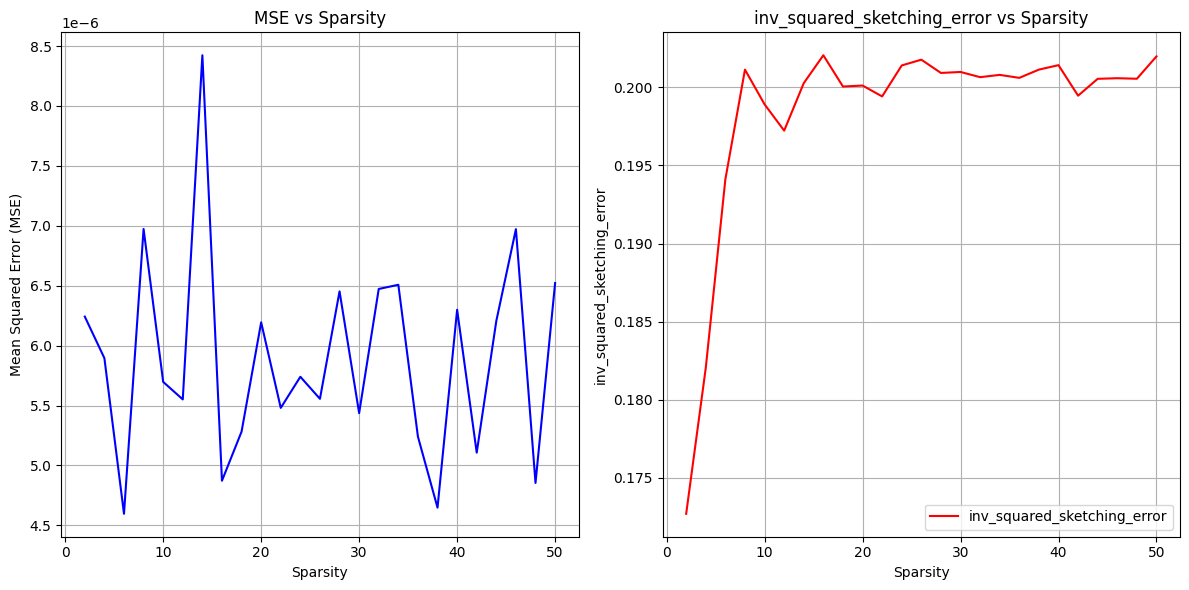

In [27]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_filtered["Sparsity"], df_filtered["MSE"], label="MSE", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sparsity")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_filtered["Sparsity"], df_filtered["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sparsity")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sparsity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

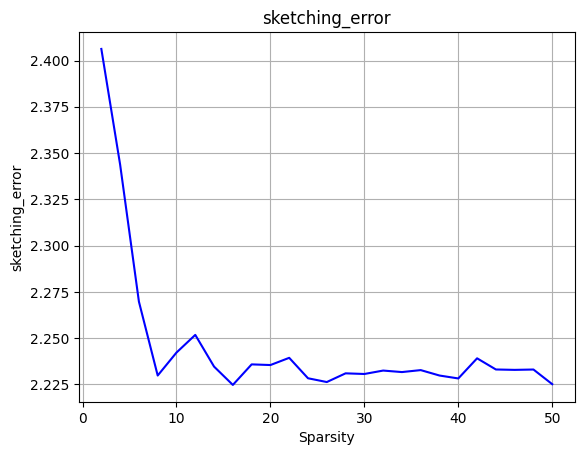

In [28]:
plt.plot(df_filtered["Sparsity"], df_filtered["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)